<a href="https://colab.research.google.com/github/tomiambro/covid_transfer_learning/blob/main/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# ! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
!pip install --upgrade git+https://github.com/fastai/fastai.git &> 2
!pip install pip install nbdev &> 2

In [46]:
from fastai.vision.all import *
from torchvision import transforms as T

import gc

In [47]:
dataset_path = 'gdrive/MyDrive/machine_learning/datasets/covid_dataset'  #change dir to your project folder
folder_path = 'gdrive/MyDrive/machine_learning/covid/'

In [48]:
from google.colab import drive

drive._mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


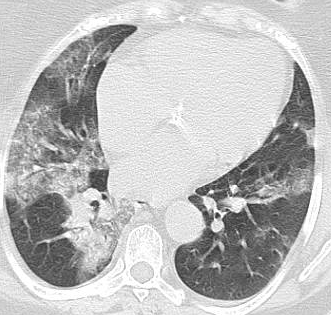

In [49]:
im = Image.open(f"{dataset_path}/COVID/Covid (1000).png")
im.to_thumb(350,350)

Create array with Path objects to imgs

In [50]:
path = Path(f"{dataset_path}")
fns = get_image_files(path)
fns

(#2481) [Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1227).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1229).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1226).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1209).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1238).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1233).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1205).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1220).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1216).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1223).png')...]

In [51]:
imgs = get_image_files(f"{dataset_path}")
imgs

(#2481) [Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1227).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1229).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1226).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1209).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1238).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1233).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1205).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1220).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1216).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1223).png')...]

In [52]:
covid = DataBlock(
    blocks=(ImageBlock, CategoryBlock(['non-COVID', 'COVID'], sort=False)), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(350,350))

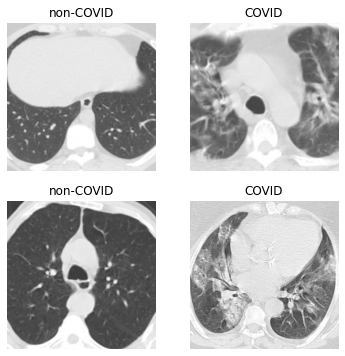

In [53]:
dls = covid.dataloaders(path)
dls.valid.show_batch(max_n=4)

In [54]:
dls.train.vocab

['non-COVID', 'COVID']

In [55]:
res34 = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

In [56]:
lr = 1e-3
res34.fine_tune(4, lr)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.820514,0.492291,0.806754,0.884774,00:43


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.403736,0.220977,0.914851,0.950617,00:57
1,0.266333,0.128263,0.956701,0.954733,00:57
2,0.163540,0.103032,0.970954,0.962963,00:57
3,0.101064,0.093087,0.973085,0.967078,00:56


In [57]:
df_rec34 = pd.DataFrame(res34.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [58]:
df_rec34

,train_loss,valid_loss,f1_score,recall_score
0,0.403736,0.220977,0.914851,0.950617
1,0.266333,0.128263,0.956701,0.954733
2,0.163540,0.103032,0.970954,0.962963
3,0.101064,0.093087,0.973085,0.967078


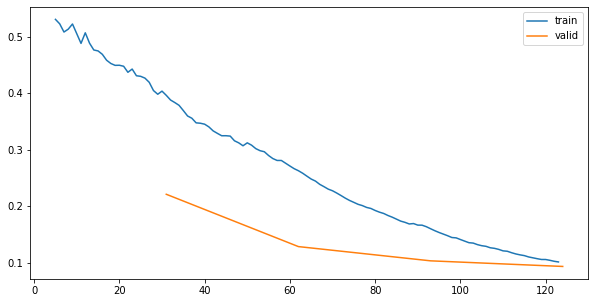

In [59]:
plt.figure(figsize=(10,5))
res34.recorder.plot_loss()

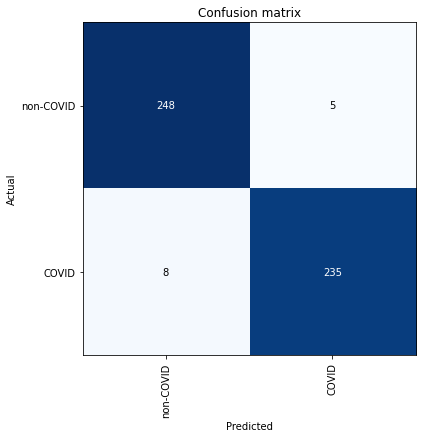

In [60]:
interp = ClassificationInterpretation.from_learner(res34)
interp.plot_confusion_matrix(figsize=(6,6))

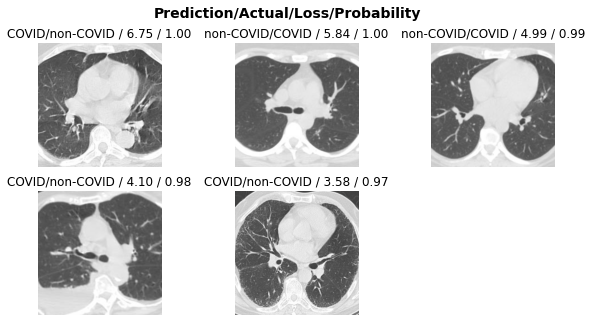

In [61]:
interp.plot_top_losses(5, figsize=(10,5))

In [62]:
res34.predict(f"{dataset_path}/COVID/Covid (1000).png")

('COVID', TensorBase(1), TensorBase([3.7307e-05, 9.9996e-01]))

In [63]:
res34.export('res34.pkl')

In [64]:
del res34
gc.collect()
torch.cuda.empty_cache()

In [65]:
covid = covid.new(
    item_tfms=Resize(350),
    batch_tfms=[DeterministicFlip, Contrast(draw=1.25)])
dls = covid.dataloaders(path)

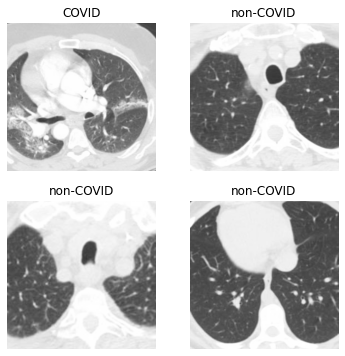

In [66]:
dls.train.show_batch(max_n=4)

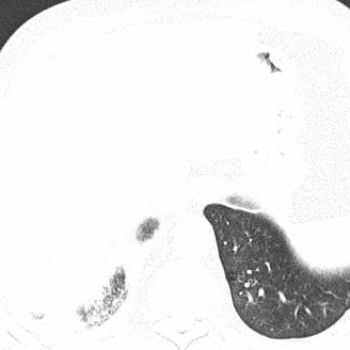

In [67]:
train_features, train_labels = next(iter(dls.train))
trans = T.ToPILImage()
trans(train_features[0])

In [68]:
res34_noise = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

In [69]:
lr = 1e-3
res34_noise.fine_tune(4, lr, freeze_epochs=2)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.913743,0.529378,0.761488,0.716049,00:45
1,0.669233,0.445272,0.839416,0.946502,00:45


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.344683,0.208689,0.920833,0.909465,00:58
1,0.252581,0.148070,0.948665,0.950617,00:58
2,0.172822,0.137095,0.946695,0.913580,00:58
3,0.127644,0.117855,0.957806,0.934156,00:58


In [70]:
df_rec34_noise = pd.DataFrame(res34_noise.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [71]:
df_rec34_noise

,train_loss,valid_loss,f1_score,recall_score
0,0.344683,0.208689,0.920833,0.909465
1,0.252581,0.148070,0.948665,0.950617
2,0.172822,0.137095,0.946695,0.913580
3,0.127644,0.117855,0.957806,0.934156


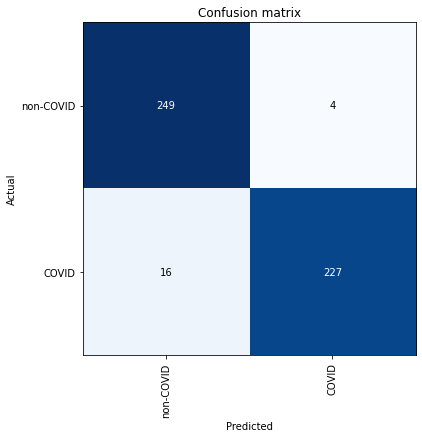

In [72]:
interp = ClassificationInterpretation.from_learner(res34_noise)
interp.plot_confusion_matrix(figsize=(6,6))

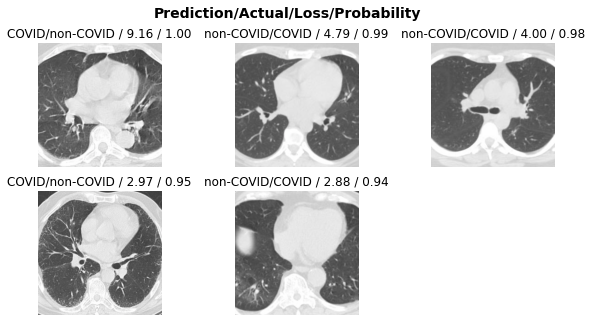

In [73]:
interp.plot_top_losses(5, figsize=(10,5))

In [75]:
res34_noise.export('res34_noise.pkl')

In [76]:
del res34_noise
gc.collect()
torch.cuda.empty_cache()

## Inference

Load the model from URL

In [77]:
res34 = load_learner(f'{folder_path}res34.pkl')

In [78]:
res34_noise = load_learner(f'{folder_path}res34_noise.pkl')

In [79]:
class Ensemble:
  def __init__(self, models : dict, vocab : list = [0, 1]):
    self.models = models
    self.vocab = vocab
    self.model_list = []
    print(f'vocab: {self.vocab}')
    for name, model in models.items():
      self.model_list.append(model)
      print(f'loaded: {name}')
  
  def calc_probas(self, item):
    probas = []
    for _, model in self.models.items():
      _, _, p = model.predict(item)
      probas.append(p.numpy())
    
    probas = np.stack(probas, axis=0)
    return probas

  def predict(self, item):
    probas = self.calc_probas(item)
    mean, std = probas.mean(axis=0), probas.std(axis=0)

    return self.vocab[mean.argmax()], mean, std
  
  def get_preds(self, dl=None, with_input=True, with_loss=True, with_decoded=True, act=None):
    if dl is None: dl = self.model_list[0].dls[1]
    predictions = []
    losses = []
    for model in self.model_list:
      inputs, preds, targs, decoded, loss = model.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)
      predictions.append(preds)
      losses.append(loss)
    
    preds = torch.stack(predictions).mean(0)
    decoded = preds.argmax(1)
    return inputs, preds, targs, decoded, torch.stack(losses, dim=1).mean(1)
    


In [80]:
en = Ensemble({'res34': res34, 'res34_noise': res34_noise}, vocab=['non-covid', 'covid'])
pred, mean, std = en.predict(f"{dataset_path}/COVID/Covid (1000).png")

vocab: ['non-covid', 'covid']
loaded: res34
loaded: res34_noise


In [81]:
en.calc_probas(f"{dataset_path}/COVID/Covid (1000).png")

array([[3.7305483e-05, 9.9996269e-01],
       [6.6701701e-05, 9.9993324e-01]], dtype=float32)

In [82]:
# inputs, predictions, targs, decoded, losses = en.get_preds(dl=dls.valid, with_input=True, with_loss=True, with_decoded=True, act=None)

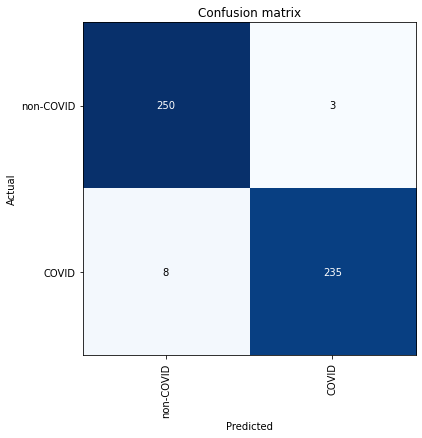

In [83]:
interp = ClassificationInterpretation.from_learner(en, dl=dls.valid)
interp.plot_confusion_matrix(figsize=(6,6))

In [84]:
!ls {folder_path}

models	res34_noise.pkl  res34.pkl


In [85]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=151TwzuC8exmzntoh-iQDXPJT71A1CcGU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=151TwzuC8exmzntoh-iQDXPJT71A1CcGU" -O res34.pkl && rm -rf /tmp/cookies.txt &> 2

--2021-12-14 02:06:12--  https://docs.google.com/uc?export=download&confirm=SE&id=151TwzuC8exmzntoh-iQDXPJT71A1CcGU
Resolving docs.google.com (docs.google.com)... 142.250.157.102, 142.250.157.101, 142.250.157.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.157.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘res34.pkl’

res34.pkl               [ <=>                ]   3.22K  --.-KB/s    in 0s      

2021-12-14 02:06:13 (23.3 MB/s) - ‘res34.pkl’ saved [3295]



In [86]:
!ls -la

total 24
drwxr-xr-x 1 root root 4096 Dec 14 01:40 .
drwxr-xr-x 1 root root 4096 Dec 14 01:05 ..
-rw-r--r-- 1 root root    0 Dec 14 02:06 2
drwxr-xr-x 4 root root 4096 Dec  3 14:33 .config
drwx------ 6 root root 4096 Dec 14 01:10 gdrive
-rw-r--r-- 1 root root 3295 Dec 14 02:06 res34.pkl
drwxr-xr-x 1 root root 4096 Dec  3 14:33 sample_data


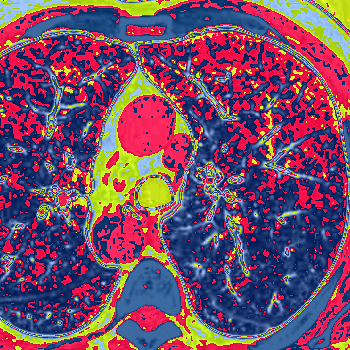

In [87]:
train_features, train_labels = next(iter(dls.train))
trans = T.ToPILImage()
trans(train_features[0])

In [88]:
print(f'{en.vocab[mean.argmax()]} with {(mean[mean.argmax()] * 100):.3f}% probability')

covid with 99.995% probability
